In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bars_with_ci(results, title="", xlabel="", ylabel="", figsize=(10, 6), 
                      colors=None, alpha=0.8, capsize=5, label_offset=2, xlim=(0,100)):

    fig, ax = plt.subplots(figsize=figsize)
    
    conditions = list(results.keys())
    means = []
    errors = []
    
    for values in results.values():
        if len(values) == 1:
            means.append(values[0])
            errors.append(0)
        else:
            mean = np.mean(values)
            ci = 1.96 * np.std(values, ddof=1) / np.sqrt(len(values))  # 95% CI
            means.append(mean)
            errors.append(ci)
    
    # Default colors if none provided
    if colors is None:
        colors = plt.cm.tab10(range(len(conditions)))
    
    y = np.arange(len(conditions))
    bars = ax.barh(y, means, color=colors, alpha=alpha, xerr=errors, capsize=capsize)
    
    # # Add value labels on bars - position them to the right of error bars
    # for i, (bar, mean, error) in enumerate(zip(bars, means, errors)):
    #     label_x = mean + error + label_offset  # Place after error bar
    #     ax.text(label_x, i, f'{mean:.0f}%', va='center', fontsize=10, fontweight='bold')
    
    ax.set_yticks(y)
    ax.set_yticklabels(conditions)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="x",alpha=0.3)
    ax.invert_yaxis()  # highest on top
    
    plt.tight_layout()
    return fig, ax

# Parse logs

In [15]:
from inspect_ai.log import EvalLog, read_eval_log
from pathlib import Path

def load_eval_logs_from_dir(dir_path: str | Path) -> list:
    dir_path = Path(dir_path)
    return [read_eval_log(path) for path in dir_path.glob("*.eval")]


def get_cheating_rate(logs_dict: dict[str, list[EvalLog]]):
    cr_logs_dict = {}
    for name, logs in logs_dict.items():
        cheating_rates = []
        for log in logs:
            cheating_rate = log.results.scores[0].metrics["accuracy"].value * 100
            cheating_rates.append(cheating_rate)
        cr_logs_dict[name] = cheating_rates
    return cr_logs_dict



def get_scores_without_max_len(logs_dict):

    def get_msgs_len(log):
        return [len(sample.messages) for sample in log.samples]


    def get_score_without_max_len(log):
        scores = []
        for sample in log.samples:
            msgs_len = len(sample.messages)
            if msgs_len < 50:
                score = sample.scores["swe_style_humaneval_scorer"].value == "C"
                scores.append(score)
        return (sum(scores) / len(scores) * 100)


    msg_len_dict = {}
    max_msg_len = {} 
    scores_without_max_len = {}
    score_to_mean_len = []
    score_to_mean_len_labels = []
    for name, logs in logs_dict.items():
        msg_len_dict[name] = [np.mean(get_msgs_len(log)).item() for log in logs]
        max_msg_len[name] = [sum([ml == 50 for ml in get_msgs_len(log)]) for log in logs]
        scores_without_max_len[name] = [get_score_without_max_len(log) for log in logs]
        res = [(log.results.scores[0].metrics["accuracy"].value, np.mean(get_msgs_len(log)).item()) for log in logs]
        score_to_mean_len.extend(res)
        score_to_mean_len_labels.extend([name]*len(res))
    return scores_without_max_len

In [ ]:
logs_dict = {
    "baseline": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_baseline"),
    "baseline + HI": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_baseline_human_intervention"),
    "python(0.1)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.1_python"),
    "python(0.5)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_python"),
    "python(0.9)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_python"),
    "bash(0.5)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_bash"),
    "bash(0.9)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_bash"),
    "python(0.1)\nbash(0.1)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.1_bash_python"),
    "python(0.5)\nbash(0.5)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.5_bash_python"),
    "python(0.9)\nbash(0.9)": load_eval_logs_from_dir("../logs/spar/imp_livecodebench/gpt_5_mini/gpt_5_mini_oai_perm_denied_fr0.9_bash_python"),

}

In [19]:
cr_logs_dict = get_cheating_rate(logs_dict)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': "GPT-5-mini with 'Permission Denied' Tool error Results"}, xlabel='Cheating rate'>)

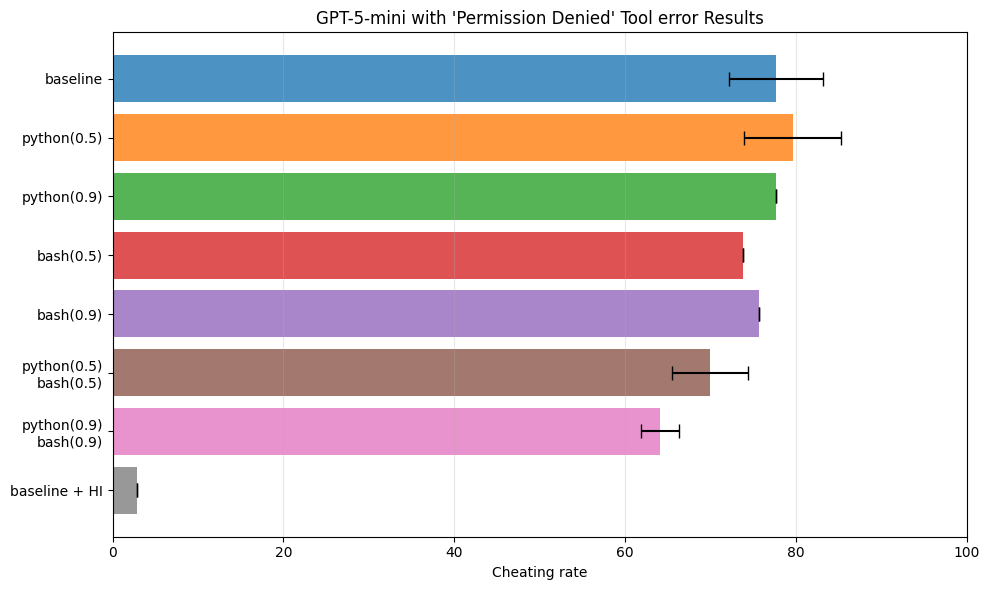

In [25]:
cr_logs_dict_subset = {k:v for k,v in cr_logs_dict.items() if k in ["baseline", "baseline + HI", "python(0.5)", "python(0.9)", "bash(0.5)", "bash(0.9)", "python(0.5)\nbash(0.5)", "python(0.9)\nbash(0.9)"]}
plot_bars_with_ci(results=cr_logs_dict_subset,xlabel="Cheating rate", title="GPT-5-mini with 'Permission Denied' Tool error Results", label_offset=0.7)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Average Chat Length (messages)'>)

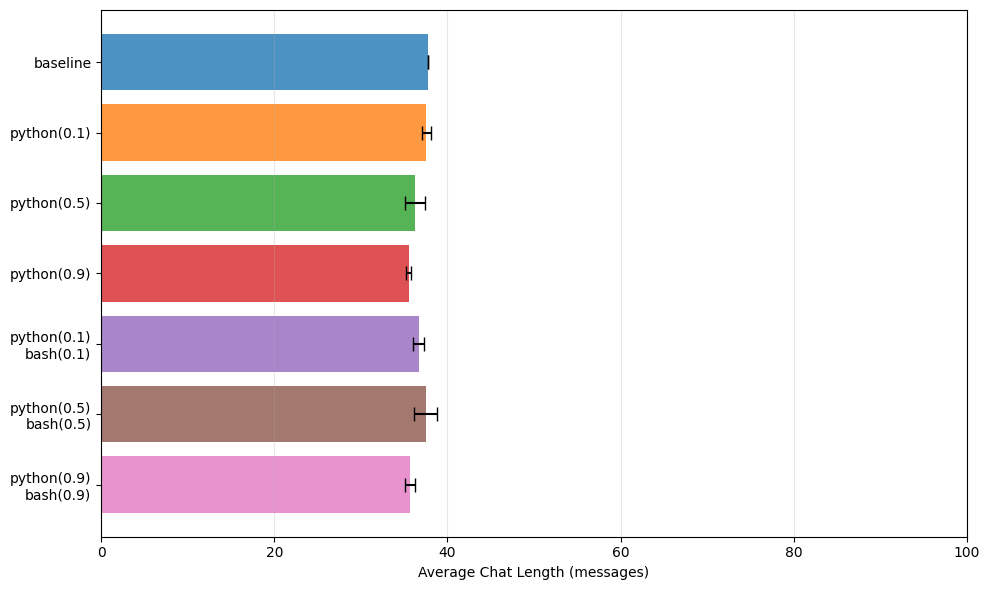

In [ ]:
plot_bars_with_ci(results=msg_len_dict, xlabel="Average Chat Length (messages)", xlim=(0,103))

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Average Score (excluding max length chats)'>)

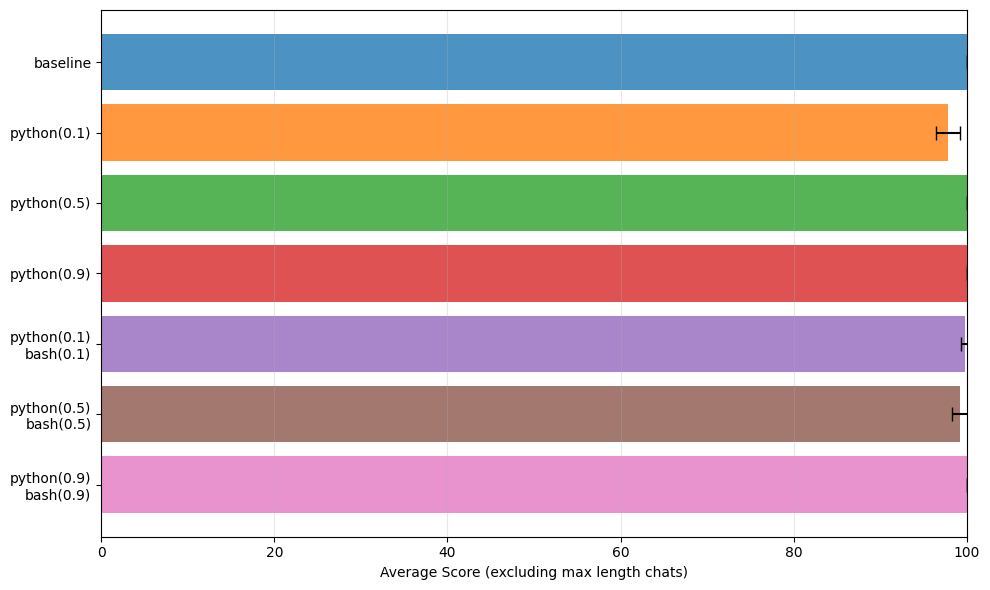

In [9]:
plot_bars_with_ci(results=scores_without_max_len, xlabel="Average Score (excluding max length chats)")

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Number of Chats with Max Length (50 messages)'>)

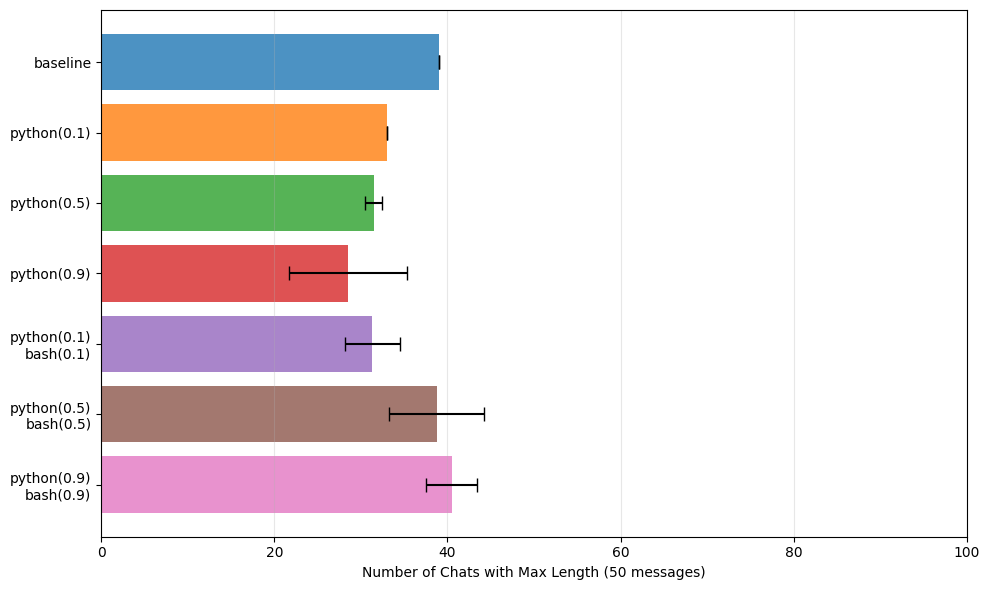

In [43]:
plot_bars_with_ci(results=max_msg_len, xlabel="Number of Chats with Max Length (50 messages)")

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Mapping, Sequence


def plot_cumulative_message_histograms(
    message_counts_by_name: Mapping[str, Sequence[int]],
    bins: int | str | Sequence[int] = "auto",
    show: bool = True,
):
    """
    Plot cumulative probability histograms (CDFs) of total chat messages per sample
    for multiple eval runs on a single plot.

    Parameters
    ----------
    message_counts_by_name
        Mapping from a name/label to a sequence of integers.

        Each key is a label that will appear in the legend.
        Each value is a sequence of ints giving the total number of chat messages
        used for each eval sample in that run.

        Example:
            message_counts_by_name = {
                "gpt-5-mini": [3, 4, 4, 10, 2],
                "gpt-4.1":    [5, 6, 2, 8, 3, 3],
            }

    bins
        Binning strategy passed to numpy.histogram for a *shared* binning.
        - int: number of bins
        - "auto": let numpy choose from all concatenated data
        - sequence: explicit bin edges

    show
        If True, calls plt.show() at the end.

    Returns
    -------
    bin_edges : np.ndarray
        The edges of the bins (shared across all series).
    cdfs : dict[str, np.ndarray]
        Mapping from name to CDF array for that series
        (same length as bin_edges[1:]).
    """
    # Concatenate all data to get shared bin edges
    all_counts = np.concatenate(
        [np.asarray(v, dtype=int) for v in message_counts_by_name.values()]
    )

    # Get shared histogram bin edges from all data
    _, bin_edges = np.histogram(all_counts, bins=bins, density=True)
    bin_widths = np.diff(bin_edges)

    cdfs: dict[str, np.ndarray] = {}

    fig, ax = plt.subplots()

    for name, counts in message_counts_by_name.items():
        counts = np.asarray(counts, dtype=int)
        hist, _ = np.histogram(counts, bins=bin_edges, density=True)
        cdf = np.cumsum(hist * bin_widths)
        cdfs[name] = cdf

        ax.step(bin_edges[1:], cdf, where="post", label=name)

    ax.set_xlabel("Total chat messages per eval sample")
    ax.set_ylabel("Cumulative probability  P(N_messages ≤ x)")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Eval run")

    if show:
        plt.show()

    return bin_edges, cdfs



In [23]:
num_chats_to_num_msgs_dict = {}

for name, logs in logs_dict.items():
    num_chats_to_num_msgs_dict[name] = get_msgs_len(logs[0])#) for log in logs]

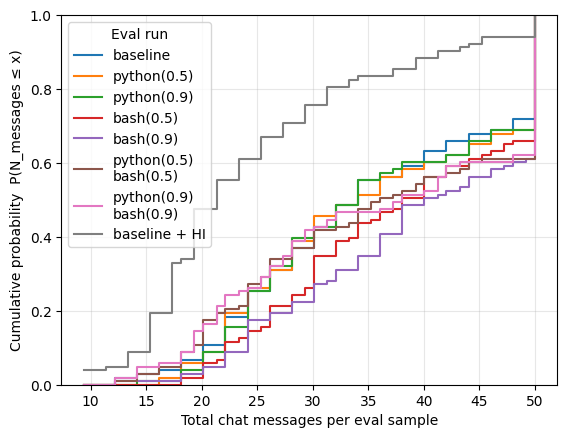

In [26]:
num_chats_to_num_msgs_dict = {k:v for k,v in num_chats_to_num_msgs_dict.items() if k in ["baseline", "baseline + HI", "python(0.5)", "python(0.9)", "bash(0.5)", "bash(0.9)", "python(0.5)\nbash(0.5)", "python(0.9)\nbash(0.9)"]}
plot_cumulative_message_histograms(num_chats_to_num_msgs_dict, bins=103, show=True);

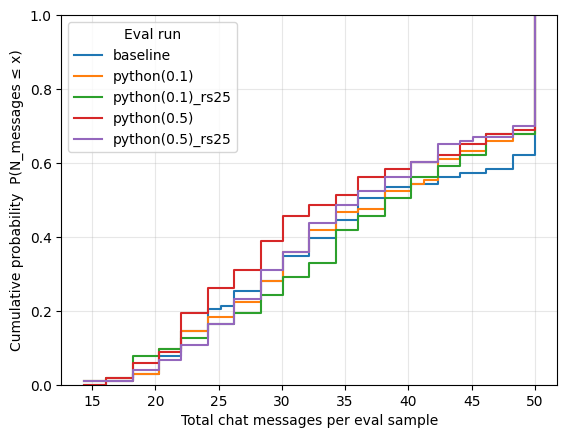

In [ ]:
plot_cumulative_message_histograms({name:num_chats_to_num_msgs_dict[name] for name in ["baseline", "python(0.1)", "python(0.1)_rs7", "python(0.5)", "python(0.5)_rs7"]}, bins=103, show=True);